In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F
import torchvision
import torchvision.transforms
import matplotlib.pyplot as plt
import numpy as np
import glob
import pandas as pd
from torch.utils.data import DataLoader
from torchsummary import summary
from IPython.core.debugger import set_trace


## Configuring sacred 

In [2]:
transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

data = torchvision.datasets.ImageFolder(
                    root='./data/trainset/',
                    transform=transforms
                    )

test_data = torchvision.datasets.ImageFolder(
                    root= './data/test/', 
                    transform=transforms)

dataset_ratio = np.array([95, 5])/100

sizes = [int(x*len(data)) for x in dataset_ratio]
sizes[0] += len(data) - sum(sizes)

train_dataset, valid_dataset = torch.utils.data.random_split(dataset=data, lengths=sizes)

train_loader = torch.utils.data.DataLoader(
                    train_dataset,
                    batch_size=64,
                    num_workers=2,
                    shuffle=True
                    )

valid_loader = torch.utils.data.DataLoader(
                    valid_dataset,
                    batch_size=64,
                    num_workers=2,
                    shuffle=True
                    )

test_loader = torch.utils.data.DataLoader(
                    test_data,
                    batch_size=64,
                    num_workers=2,
                    shuffle=False
                    )
print(data)
print(valid_dataset)

Dataset ImageFolder
    Number of datapoints: 19998
    Root Location: ./data/trainset/
    Transforms (if any): Compose(
                             ToTensor()
                         )
    Target Transforms (if any): None


In [3]:
cuda_available = torch.cuda.is_available()
print(cuda_available)

True


## Hyper-parameters of the model

In [ ]:
learning_rate = 1e-3
lr0 = 0.002
optim = 'adam'
num_epochs = 10
store_every = 200

## Defining a residual convolution block to be used in the models

In [5]:
class ResidualConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=(3, 3), padding=1, activation = nn.ReLU):
        super(ResidualConv, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.activation = activation
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size)
        self.relu1 = nn.ReLU(in_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size)
        self.relu2 = nn.ReLU(in_channels)
        
        if in_channels != out_channels:
#             self.projected_conv = self.conv1x1(in_channels, out_channels)
            self.project_linear = nn.Linear(in_channels, out_channels)
    def forward(x):
        identity = x

        out = self.conv1(x)
        out = self.relu1(out)

        out = self.conv2(out)
        if self.in_channels == self.out_channels:
            out += identity
        else:
            out += self.project_linear(identity)
        out = self.relu2(out)
        
    def conv1x1(in_channels, out_channels, stride=1):
        """1x1 convolution"""
        print()
        return nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False)

In [6]:
class ResidualClassifier(nn.Module):
    def __init__(self):
        super(ResidualClassifier, self).__init__()
        self.conv = nn.Sequential(
            # Layer 1
            ResidualConv(in_channels=3, out_channels=16, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 2
            ResidualConv(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 3
            ResidualConv(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            )
        # Logistic Regression
        self.clf = nn.Linear(64, 2)
        
        def forward(x):
            return self.clf(self.conv(x).squeeze())

## Vanila CNN

In [7]:
class VanilaCNN(nn.Module):
    """Convnet Classifier"""
    def __init__(self):
        super(VanilaCNN, self).__init__()
        self.conv = nn.Sequential(
            # Layer 1
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 2
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 3
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 4
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 5
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 6
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        )
        # Logistic Regression
        self.clf = nn.Linear(256, 2)

    def forward(self, x):
        return self.clf(self.conv(x).squeeze())

## First Implementation

In [8]:
classifiers = ['ResidualClassifier', "VanilaCNN"]
my_classifier = 'VanilaCNN'

if my_classifier=='ResidualClassifier':
    model = ResidualClassifier()
elif my_classifier=='VanilaCNN':
    model = VanilaCNN() 
    
if cuda_available:
    model = model.cuda()
if optim == 'sgd':
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
elif optim == 'adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [9]:
print(model)

VanilaCNN(
  (conv): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1)

In [10]:
summary(model, input_size=(3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 64, 64]             448
              ReLU-2           [-1, 16, 64, 64]               0
         MaxPool2d-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           4,640
              ReLU-5           [-1, 32, 32, 32]               0
         MaxPool2d-6           [-1, 32, 16, 16]               0
            Conv2d-7           [-1, 64, 16, 16]          18,496
              ReLU-8           [-1, 64, 16, 16]               0
         MaxPool2d-9             [-1, 64, 8, 8]               0
           Conv2d-10            [-1, 128, 8, 8]          73,856
             ReLU-11            [-1, 128, 8, 8]               0
        MaxPool2d-12            [-1, 128, 4, 4]               0
           Conv2d-13            [-1, 128, 4, 4]         147,584
             ReLU-14            [-1, 12

## Second implementation

In [ ]:
class Trainer2():
    def __init__(self,  model, optimizer, criterion, train_loader, valid_loader, test_loader):
        super(Trainer2, self).__init__()
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.train_loader = train_loader
        self.valid_loader = valid_loader
        self.test_loader = test_loader
        
    def evaluate(self, dataset_loader, criterion):
        LOSSES = 0
        COUNTER = 0
        for batch in dataset_loader:
            optimizer.zero_grad()

            x, y = batch
    #             x = x.view(-1,1,28,28)
            y = y.view(-1)
            if cuda_available:
                x = x.cuda()
                y = y.cuda()

            loss = criterion(model(x), y)
            n = y.size(0)
            LOSSES += loss.sum().data.cpu().numpy() * n
            COUNTER += n

        return LOSSES / float(COUNTER)
    
    def accuracy(self, proba, y):
        correct = torch.eq(proba.max(1)[1], y).sum().type(torch.FloatTensor)
        return correct / y.size(0)
    
    def adjust_lr(self, optimizer, epoch, total_epochs):
        lr = lr0 * (0.1 ** (epoch / float(total_epochs)))
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
            
    def train_model(self):
        LOSSES = 0
        COUNTER = 0
        ITERATIONS = 0
        learning_curve_nll_train = list()
        learning_curve_nll_test = list()
        learning_curve_acc_train = list()
        learning_curve_acc_test = list()
        for e in range(num_epochs):
            for batch in train_loader:
                optimizer.zero_grad()
                x, y = batch
    #             x = x.view(-1,1,28,28)
                y = y.view(-1)
                if cuda_available:
                    x = x.cuda()
                    y = y.cuda()
                loss = criterion(model(x), y)
                loss.backward()
                optimizer.step()

                n = y.size(0)
                LOSSES += loss.sum().data.cpu().numpy() * n
                COUNTER += n
                ITERATIONS += 1
                if ITERATIONS%(store_every/5) == 0:
                    avg_loss = LOSSES / float(COUNTER)
                    LOSSES = 0
                    COUNTER = 0
                    print(" Iteration {}: TRAIN {}".format(
                        ITERATIONS, avg_loss))

                if ITERATIONS%(store_every) == 0:     

                    train_loss = self.evaluate(train_loader, criterion)
                    learning_curve_nll_train.append(train_loss)
                    test_loss = self.evaluate(test_loader, criterion)
                    learning_curve_nll_test.append(test_loss)

                    train_acc = self.evaluate(train_loader, self.accuracy)
                    learning_curve_acc_train.append(train_acc)
                    test_acc = self.evaluate(valid_loader, self.accuracy)
                    learning_curve_acc_test.append(test_acc)

                    print(" [NLL] TRAIN {} / TEST {}".format(
                        train_loss, test_loss))
                    print(" [ACC] TRAIN {} / TEST {}".format(
                        train_acc, test_acc))

            self.adjust_lr(optimizer, e+1, num_epochs)

        return learning_curve_nll_train, \
               learning_curve_nll_test, \
               learning_curve_acc_train, \
               learning_curve_acc_test, 
    
    def predict(self):
        results = [[]]
        targetss = [[]]
        for batch_idx, (inputs, targets) in enumerate(valid_loader):
            if cuda_available:
                inputs, targets = inputs.cuda(), targets.cuda()
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            results  = np.append(results, predicted.cpu().numpy())
            targetss = np.append(targetss, targets.cpu().numpy())

        results = np.int8(results)
        return results, targetss

trainer = Trainer2(model, optimizer, criterion, train_loader, valid_loader, test_loader)

In [13]:
nll_train, nll_test, acc_train, acc_test =  trainer.train_model()
print('Done...')

 Iteration 40: TRAIN 0.693091468513012
 Iteration 80: TRAIN 0.693446832895279
 Iteration 120: TRAIN 0.693283760547638
 Iteration 160: TRAIN 0.6932155951857567
 Iteration 200: TRAIN 0.6930956304073334
 [NLL] TRAIN 0.69320821227811 / TEST 0.6818849448562503
 [ACC] TRAIN 0.5001315859419602 / TEST 0.49749749863111936
 Iteration 240: TRAIN 0.6934966653585434
 Iteration 280: TRAIN 0.6929104775190353
 Iteration 320: TRAIN 0.6936675446354048
 Iteration 360: TRAIN 0.693706537783146
 Iteration 400: TRAIN 0.6937692925333977
 [NLL] TRAIN 0.693881037677738 / TEST 0.7319280508518887
 [ACC] TRAIN 0.4998684140517653 / TEST 0.5025025033974672
 Iteration 440: TRAIN 0.6933264687657357
 Iteration 480: TRAIN 0.6939106807112694
 Iteration 520: TRAIN 0.6937819838523864
 Iteration 560: TRAIN 0.6936147212982178
 Iteration 600: TRAIN 0.6940081086826063
 [NLL] TRAIN 0.6932996274439985 / TEST 0.6755662560462952
 [ACC] TRAIN 0.5001315858698034 / TEST 0.49749749851179076
 Iteration 640: TRAIN 0.6932983890175819
 It

14


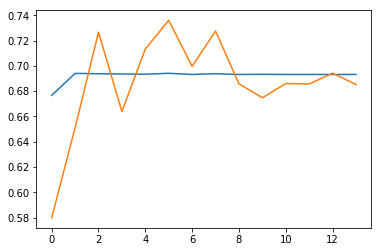

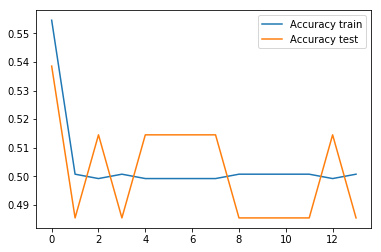

In [88]:
print(len(acc_train))
plt.figure(1)
plt.plot(range(len(nll_train)), nll_train, label="NLL train" )
plt.plot(range(len(nll_test)), nll_test,   label="NLL test" )
plt.figure(2)
plt.plot(range(len(acc_train)), acc_train, label="Accuracy train" )
plt.plot(range(len(acc_test)), acc_test,   label="Accuracy test" )
plt.legend()
plt.show()

## Confusion Matrix

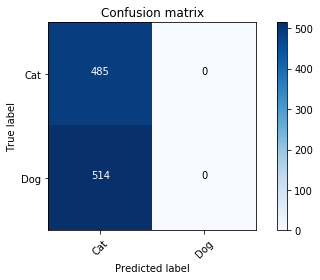

In [89]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix\
y_pred, y_test = trainer.predict()
class_names = ['Cat', 'Dog']
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')


plt.show()


## Evaluating of testset 

In [ ]:
results = [[]]
for batch_idx, (inputs, targets) in enumerate(test_loader):
    if cuda_available:
        inputs, targets = inputs.cuda(), targets.cuda()
    outputs = clf(inputs)
    _, predicted = torch.max(outputs.data, 1)
    results = np.append(results, predicted.cpu().numpy())

results = np.int8(results)

## Creating submission csv file

In [ ]:
df = pd.DataFrame({ 'id': range(1, len(results)+1),
                    'label': results})
df['label'].replace([0,1], ['Cat','Dog'], inplace=True)
df[df.columns].to_csv('submisstion.csv',index=False)
print('Done...')

In [ ]:
def trainer1():
    for epoch in range(epoches):
        losses = []
        # Train
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            if cuda_available:
                inputs, targets = inputs.cuda(), targets.cuda()
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            losses.append(loss.data.item())


            if batch_idx%50==0:
                print('Epoch : %d Loss : %.3f ' % (epoch, np.mean(losses)))

        # Evaluate
        model.eval()
        total = 0
        correct = 0
        for batch_idx, (inputs, targets) in enumerate(valid_loader):
            if cuda_available:
                inputs, targets = inputs.cuda(), targets.cuda()

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += predicted.eq(targets.data).cpu().sum()

        print('Epoch : %d Test Acc : %.3f' % (epoch, 100.*correct/total))
        print('--------------------------------------------------------------')
        model.train()
    print('Done...')

trainer1()